<a href="https://colab.research.google.com/github/lromano97/text-mining/blob/main/variable-talks__tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏷️ talks__tags

Como resultado del web scrapping en la página TED, vemos que la variable `talks_tags` de cada charla puede tener múltiples valores (desde 0 tags hasta charlas que tienen 31).

La solución principal a nuestro modelo sería crear modelos que soporten variables target [*multioutput* y *multiclass*](https://scikit-learn.org/stable/modules/multiclass.html), pero entendemos que podría simplificarse su solución a uno multiclass.

La exploración de la variable `talks_tags` en esta notebook pretende ver la viabilidad de simplificarlo en ese sentido.


In [1]:
# activando Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd "/content/gdrive/My Drive/Colab Notebooks/Text Mining/TopicsTED"

/content/gdrive/My Drive/Colab Notebooks/Text Mining/TopicsTED


In [ ]:
# preparación del entorno

# librerías de uso común
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import re
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# librerías y dependencias para npl
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')


# Sin warnings
import warnings
warnings.filterwarnings('ignore')

# impresiones compactas
import pprint
pp = pprint.PrettyPrinter(compact=True)

In [4]:
# importando base de datos y extrayendo variables de interés
datos = pd.read_csv('TED_Talk.csv', index_col='talk__id')
datos = datos[['talks__tags', 'number_of__tags']]

# convirtiendo la variable 'talks__tags' en una lista
datos['talks__tags'] = datos['talks__tags'].apply(lambda x: ast.literal_eval(x))
datos.head(3)

,talks__tags,number_of__tags
talk__id,,
66,"[creativity, culture, dance, education, parent...",7
2405,"[comedy, curiosity, communication, humor, tech...",5
1569,"[body language, brain, business, psychology, s...",7


## Exploratorio de la variable talks_tags

Las charlas TED tiene múltiples tags, algunas de ella 0 y algunas pocas hasta 31 tags.

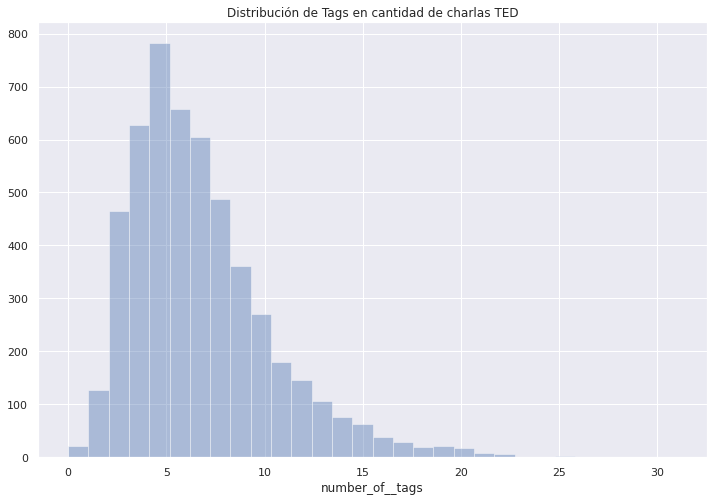

In [8]:
#datos['number_of__tags'].value_counts()
sns.distplot(datos["number_of__tags"]
             , hist=True, kde=False, bins=30).set_title('Distribución de Tags en cantidad de charlas TED')
sns.set(rc={'figure.figsize':(100,8)})

El dataset contiene 347 labels, algunos de ellos con presencia en solo una o dos de las más de 5.000 charlas TED.

In [11]:
# generación de data set para análisis de tags.
s = datos.apply(lambda x: pd.Series(x['talks__tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'temas'
temas_df = datos.drop('talks__tags', axis=1).join(s)
temas_df = temas_df.dropna()
temas_df = temas_df[['temas']]

# conteo de valores únicos en la variable theme
temas_df['temas'].value_counts()

science          1164
technology       1159
culture           783
TED-Ed            748
society           679
                 ... 
pain                2
NASA                2
goal-setting        1
crowdsourcing       1
Hinduism            1
Name: temas, Length: 347, dtype: int64

In [12]:
#Verificamos el balance de clases
pop_temas = pd.DataFrame(temas_df['temas'].value_counts()).reset_index()
pop_temas.columns = ['temas', 'talks']

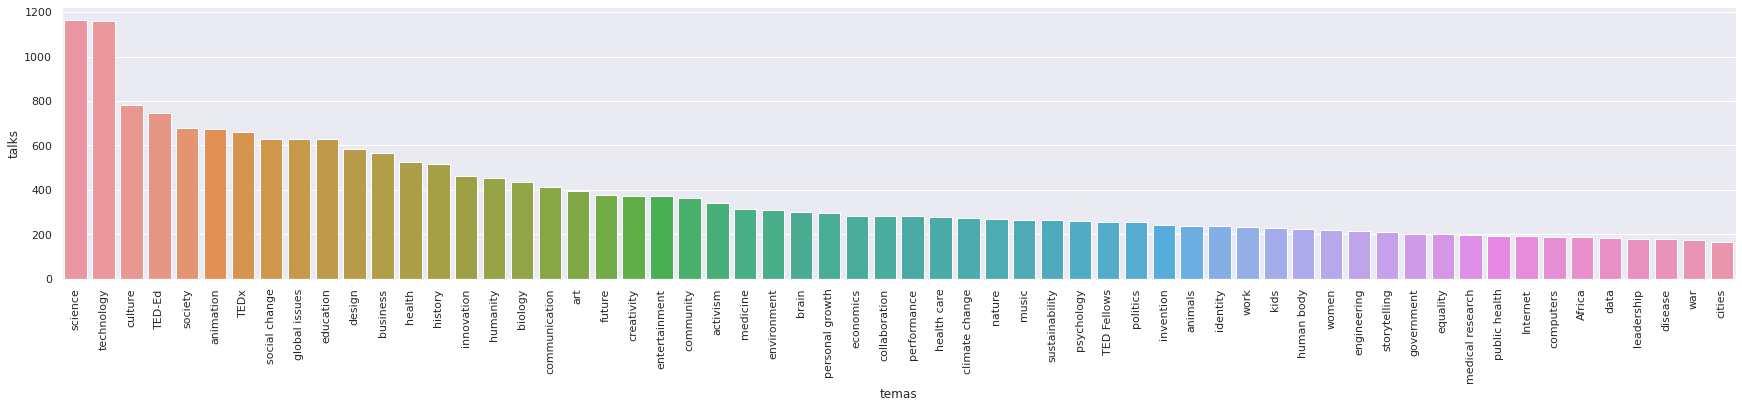

In [14]:
plt.figure(figsize=(30,5))
sns.barplot(x='temas', y='talks', data=pop_temas.head(60))
plt.xticks(rotation=90)
plt.show()

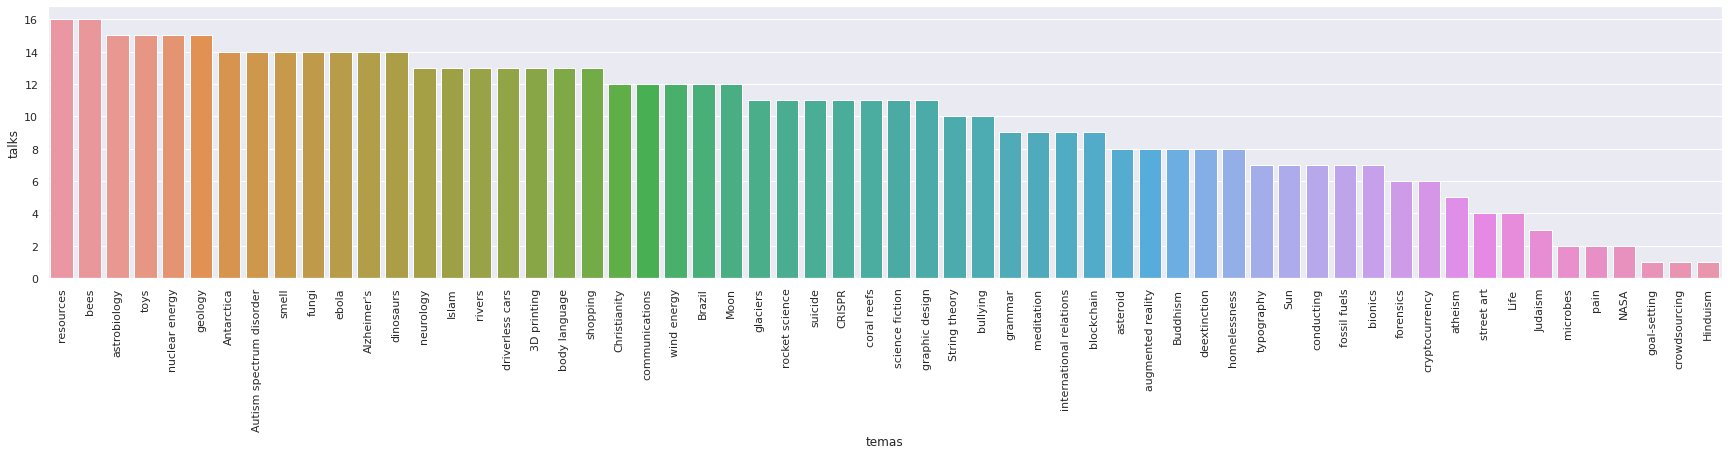

In [16]:
plt.figure(figsize=(30,5))
sns.barplot(x='temas', y='talks', data=pop_temas.tail(60))
plt.xticks(rotation=90)
plt.show()

## Preprocesamiento de la variable talks__tags

Para poder reducir la dimensionalidad de la variable `talks__tags`, necesitamos aplicar los siguientes pasos de preprocesamiento:

- [ ] Eliminar los espacios (3D printing -> 3d_printing): el uso de synsets no reconoce las ngrams separadas por espacios, pero sí por letras 
- [ ] Colocar todas las palabras en minúscula: en particular por ordenamiento
- [ ] Eliminar algunos tags: como el caso de los referidos a TED*** o que no tengan un Synset asociado

In [35]:
# Creando una lista con los talks__tags
temas = list(set(temas_df['temas']))

# Colocando todo el texto en minúscula
for i in range(len(temas)):
    temas[i] = temas[i].lower()

# Eliminando los tags TED*
ted = re.compile("ted*.")
tedlist = list(filter(ted.match, temas))
temas = [word for word in temas if word not in tedlist]
 
# Remplazando espacios por el caracter _
temas = [sub.replace(' ', '_') for sub in temas]

# Ordenando la lista
temas.sort()
pp.pprint(temas)

['3d_printing', 'activism', 'addiction', 'africa', 'aging', 'agriculture', 'ai',
 'aids', 'algorithm', 'aliens', "alzheimer's", 'ancient_world', 'animals',
 'animation', 'antarctica', 'anthropocene', 'anthropology', 'archaeology',
 'architecture', 'art', 'asia', 'asteroid', 'astrobiology', 'astronomy',
 'atheism', 'audacious_project', 'augmented_reality',
 'autism_spectrum_disorder', 'bacteria', 'beauty', 'bees',
 'behavioral_economics', 'best_of_the_web', 'big_bang', 'biodiversity',
 'bioethics', 'biology', 'biomimicry', 'bionics', 'biosphere', 'biotech',
 'birds', 'blindness', 'blockchain', 'body_language', 'books', 'botany',
 'brain', 'brazil', 'buddhism', 'bullying', 'business', 'cancer', 'capitalism',
 'chemistry', 'china', 'christianity', 'cities', 'climate_change', 'code',
 'cognitive_science', 'collaboration', 'comedy', 'communication',
 'communications', 'community', 'compassion', 'computers', 'conducting',
 'consciousness', 'conservation', 'consumerism', 'coral_reefs', 'coron

# Reducción de la dimensionalidad

## Affinity Propagation Clustering Algorithm

Usando el algoritmo *Affinity Propagation Clustering Algorithm* de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html) vamos a intentar reducir la dimensionalidad de nuestras 350 tags.

Básicamente se va a utilizar los synsets de cada palabra. Es importante en este punto identificar y eliminar o remplazar las palabras que no tengan synset dado que la posterior aplicación del modelo generará error.



In [36]:
sin_synset = []
for tema in temas:
    try:
        print(tema, wn.synsets(tema)[0])
    except:
        sin_synset.append(tema)
        print(tema, 'SIN SYNSET')

3d_printing SIN SYNSET
activism Synset('activism.n.01')
addiction Synset('addiction.n.01')
africa Synset('africa.n.01')
aging Synset('ripening.n.02')
agriculture Synset('agribusiness.n.01')
ai Synset('army_intelligence.n.01')
aids Synset('aids.n.01')
algorithm Synset('algorithm.n.01')
aliens Synset('foreigner.n.01')
alzheimer's Synset('alzheimer's_disease.n.01')
ancient_world SIN SYNSET
animals Synset('animal.n.01')
animation Synset('animation.n.01')
antarctica Synset('antarctica.n.01')
anthropocene SIN SYNSET
anthropology Synset('anthropology.n.01')
archaeology Synset('archeology.n.01')
architecture Synset('architecture.n.01')
art Synset('art.n.01')
asia Synset('asia.n.01')
asteroid Synset('asteroid.n.01')
astrobiology Synset('exobiology.n.01')
astronomy Synset('astronomy.n.01')
atheism Synset('atheism.n.01')
audacious_project SIN SYNSET
augmented_reality SIN SYNSET
autism_spectrum_disorder SIN SYNSET
bacteria Synset('bacteria.n.01')
beauty Synset('beauty.n.01')
bees Synset('bee.n.01'

In [37]:
pp.pprint(sin_synset)

['3d_printing', 'ancient_world', 'anthropocene', 'audacious_project',
 'augmented_reality', 'autism_spectrum_disorder', 'behavioral_economics',
 'best_of_the_web', 'biomimicry', 'blockchain', 'coronavirus', 'crispr',
 'crowdsourcing', 'cryptocurrency', 'cyber_security', 'decision-making',
 'deextinction', 'driverless_cars', 'global_issues', 'goal-setting',
 'indigenous_peoples', 'industrial_design', 'international_development',
 'international_relations', 'justice_system', 'lgbtqia+', 'machine_learning',
 'marine_biology', 'medical_imaging', 'medical_research', 'mission_blue',
 'natural_disaster', 'online_privacy', 'personal_growth', 'product_design',
 'public_health', 'public_space', 'renewable_energy', 'rocket_science',
 'sexual_violence', 'social_change', 'social_media', 'storytelling',
 'street_art', 'synthetic_biology', 'ux_design', 'wind_energy',
 'women_in_business', 'work-life_balance']


In [38]:
temas = [word for word in temas if word not in sin_synset]
pp.pprint(temas)

['activism', 'addiction', 'africa', 'aging', 'agriculture', 'ai', 'aids',
 'algorithm', 'aliens', "alzheimer's", 'animals', 'animation', 'antarctica',
 'anthropology', 'archaeology', 'architecture', 'art', 'asia', 'asteroid',
 'astrobiology', 'astronomy', 'atheism', 'bacteria', 'beauty', 'bees',
 'big_bang', 'biodiversity', 'bioethics', 'biology', 'bionics', 'biosphere',
 'biotech', 'birds', 'blindness', 'body_language', 'books', 'botany', 'brain',
 'brazil', 'buddhism', 'bullying', 'business', 'cancer', 'capitalism',
 'chemistry', 'china', 'christianity', 'cities', 'climate_change', 'code',
 'cognitive_science', 'collaboration', 'comedy', 'communication',
 'communications', 'community', 'compassion', 'computers', 'conducting',
 'consciousness', 'conservation', 'consumerism', 'coral_reefs', 'corruption',
 'countdown', 'creativity', 'crime', 'culture', 'curiosity', 'dance',
 'dark_matter', 'data', 'death', 'demo', 'democracy', 'depression', 'design',
 'dinosaurs', 'disability', 'discove

### Wu-Palmer Similarity

Usando la distancia **Wu-Palmer Similarity** y cambiando el parámetro `affinity`.

In [39]:
# Aplicando el modelo APC con la distancia Wu-Palmer Similarity

words = np.asarray(temas) # So that indexing with a list will work
similarity = np.array([[wn.synsets(w1)[0].wup_similarity(wn.synsets(w2)[0]) for w1 in words] for w2 in words])
similarity[similarity == None] = 0

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *aging:* aging, climate_change, evolution, sex
 - *animals:* aliens, animals, bacteria, bees, birds, dinosaurs, drones, entrepreneur, fish, insects, kids, microbes, refugees, trees, virus, women, youth
 - *architecture:* architecture, library, plants, prison, theater
 - *art:* art, books, dance, film, innovation, maps, museums, painting, transportation
 - *biodiversity:* biodiversity, diversity
 - *biology:* astrobiology, biology, biotech, genetics, medicine, microbiology, neurology, neuroscience, prosthetics, surgery
 - *china:* biosphere, brazil, china, cities, egypt, india, middle_east, united_states
 - *consciousness:* alzheimer's, consciousness, curiosity, depression, mental_health, self
 - *creativity:* atheism, consumerism, creativity, democracy, ethics, invention, meditation, pain, smell
 - *emotions:* animation, compassion, emotions, empathy, fear, happiness, health, life, love, potential, slavery
 - *energy:* electricity, energy, nuclear_energy, solar_energy, weather
 - *e

In [40]:
affprop = AffinityPropagation(affinity="euclidean", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *aids:* aids, alzheimer's, blindness, cancer, disability, disease, ebola, health, illness, ptsd
 - *antarctica:* africa, antarctica, asia, coral_reefs, europe, glaciers, south_america
 - *bacteria:* aliens, animals, bacteria, bees, birds, dinosaurs, drones, entrepreneur, fish, insects, kids, microbes, refugees, trees, virus, women, youth
 - *beauty:* beauty, biodiversity, corruption, diversity, equality, fashion, future, history, humanity, identity, infrastructure, mindfulness, nature, personality, productivity, sound, space, sustainability
 - *cities:* biosphere, brazil, china, cities, egypt, india, middle_east, united_states
 - *code:* body_language, code, comedy, demo, graphic_design, humor, language, literature, music, poetry, science_fiction, software
 - *community:* ai, botany, buddhism, business, capitalism, community, culture, data, family, flight, fungi, gender, government, hinduism, islam, judaism, law, military, nasa, primates, society, solar_system
 - *electricity:* clim

### Path similarity

In [41]:
# Aplicando el modelo APC con la distancia Path Similarity

words = np.asarray(temas) # So that indexing with a list will work
similarity = np.array([[wn.synsets(w1)[0].path_similarity(wn.synsets(w2)[0]) for w1 in words] for w2 in words])
similarity[similarity == None] = 0

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *activism:* activism, policy
 - *aging:* aging, climate_change, evolution, sex
 - *ai:* ai, family, nasa
 - *architecture:* architecture, library, plants, prison, theater
 - *art:* art, dance, innovation, maps, museums, painting, toys, transportation
 - *bacteria:* aliens, bacteria, entrepreneur, kids, microbes, refugees, trees, virus, women, youth
 - *bees:* bees, drones, insects
 - *biodiversity:* biodiversity, diversity
 - *biology:* astrobiology, biology, biotech, genetics, microbiology, neuroscience
 - *birds:* animals, birds, dinosaurs, fish
 - *china:* brazil, china, egypt, india, united_states
 - *consciousness:* alzheimer's, consciousness, curiosity, depression, mental_health, self
 - *creativity:* consumerism, creativity, democracy, invention, meditation, pain
 - *disability:* blindness, disability, ebola
 - *discovery:* collaboration, communication, conducting, discovery, hearing, interview, protest, public_speaking, shopping, violence, war
 - *disease:* aids, cancer, dis

### Leacock Chordorow (LCH) similarity

In [42]:
# Aplicando el modelo APC con la distancia Leacock Chordorow (LCH) similarity

words = np.asarray(temas) # So that indexing with a list will work
similarity = np.array([[wn.synsets(w1)[0].lch_similarity(wn.synsets(w2)[0]) for w1 in words] for w2 in words])
similarity[similarity == None] = 0

affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

WordNetError: ignored

# Código de exploración


In [ ]:
# Sinónimos --------------------
synonyms = []
for syn in wn.synsets('sun'):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())
pp.pprint(set(synonyms))

{'Dominicus', "Lord's_Day", 'Sun', 'Sunday', 'insolate', 'solarise', 'solarize',
 'sun', 'sunbathe', 'sunlight', 'sunshine'}


In [ ]:
# jugando con los tags de TED
cb = wn.synsets('astronomy')[0]
ib = wn.synsets('sun')[4]
cb.wup_similarity(ib)

# 0-0: 10.5%
# 0-1:  8.7%
# 0-2: 11.1%
# 0-3: 10.5%
# 0-4: 20.0%
# 0-5: nada 
# 0-6: nada
# 0-7: Error, naturalmente

0.2

In [43]:
wn.synsets('astronomy')

[Synset('astronomy.n.01')]